In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple, defaultdict
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [41]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class HangmanEnvironment:
    def __init__(self, word, max_guesses=6):
        self.word = word.lower()
        self.word_length = len(word)
        self.max_word_length = 30
        self.max_guesses = max_guesses
        self.reset()
    
    def reset(self):
        self.guessed_letters = set()
        self.num_guesses = 0
        self.current_state = ['_'] * self.word_length
        return self._get_state_representation()
    
    def _get_state_representation(self):
        # Create binary vector for guessed letters
        alphabet_state = np.zeros(26)
        for letter in self.guessed_letters:
            idx = ord(letter) - ord('a')
            alphabet_state[idx] = 1
        
        # Create word state matrix (max_length × 27)
        word_state = np.zeros((self.max_word_length, 27))
        for i in range(self.word_length):
            if self.current_state[i] == '_':
                word_state[i, 26] = 1  # mask token
            else:
                word_state[i, ord(self.current_state[i]) - ord('a')] = 1
                
        # Pad remaining positions
        for i in range(self.word_length, self.max_word_length):
            word_state[i, 26] = 1
        
        return {
            'alphabet_state': alphabet_state,
            'word_state': word_state,
            'word_length': self.word_length,
            'num_guesses': self.num_guesses
        }
    
    def step(self, action):
        letter = chr(action + ord('a'))
        
        if letter in self.guessed_letters:
            return self._get_state_representation(), -5.0, True  # Heavy penalty for repeated guess
        
        self.guessed_letters.add(letter)
        self.num_guesses += 1
        
        # Check if letter is in word
        found = False
        num_occurrences = 0
        for i, char in enumerate(self.word):
            if char == letter:
                self.current_state[i] = letter
                found = True
                num_occurrences += 1
        
        # Calculate reward
        if found:
            reward = num_occurrences  # Reward for each correct letter
            if '_' not in self.current_state:
                reward += 10.0  # Bonus for completing word
                done = True
            else:
                done = False
        else:
            reward = -np.log(self.num_guesses + 1)  # Logarithmic penalty
            done = False
        
        # Check if exceeded max guesses
        if self.num_guesses >= self.max_guesses:
            reward = -10.0  # Large penalty for failing to solve
            done = True
        
        return self._get_state_representation(), reward, done

class HangmanDQN(nn.Module):
    def __init__(self, max_word_length=30):
        super(HangmanDQN, self).__init__()
        
        # Simplified CNN
        self.conv = nn.Conv1d(
            in_channels=27,
            out_channels=32,   # Reduced from 64
            kernel_size=3,
            padding=1
        )
        self.batch_norm = nn.BatchNorm1d(32)
        
        # Single-layer LSTM
        self.lstm = nn.LSTM(
            input_size=32,     # Reduced from 64
            hidden_size=64,    # Reduced from 128
            num_layers=1,      # Reduced from 2
            batch_first=True,
            dropout=0.1        # Reduced dropout
        )
        
        # Simplified combination layers
        self.combine_features = nn.Sequential(
            nn.Linear(64 + 26 + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 26)
        )

    def forward(self, state):
        """Forward pass with the same logic but simplified architecture"""
        if not isinstance(state['word_state'], torch.Tensor):
            word_state = torch.FloatTensor(state['word_state']).unsqueeze(0)
            alphabet_state = torch.FloatTensor(state['alphabet_state']).unsqueeze(0)
            num_guesses = torch.FloatTensor([state['num_guesses']]).unsqueeze(0)
            word_lengths = torch.LongTensor([state['word_length']])
        else:
            word_state = state['word_state']
            alphabet_state = state['alphabet_state']
            num_guesses = state['num_guesses']
            word_lengths = state['word_length']

        batch_size = word_state.size(0)
        device = word_state.device

        # CNN processing
        word_state = word_state.transpose(1, 2)
        conv_out = self.conv(word_state)
        conv_out = self.batch_norm(conv_out)
        conv_out = torch.relu(conv_out)
        conv_out = conv_out.transpose(1, 2)

        try:
            # Pack sequence for LSTM
            packed_sequence = nn.utils.rnn.pack_padded_sequence(
                conv_out,
                word_lengths.cpu(),
                batch_first=True,
                enforce_sorted=False
            )

            # LSTM processing
            self.lstm.flatten_parameters()
            lstm_out, _ = self.lstm(packed_sequence)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        except RuntimeError as e:
            lstm_out = self.lstm(conv_out)[0]

        # Get last relevant output
        lstm_features = torch.zeros(batch_size, 64, device=device)  # Changed to 64
        for i in range(batch_size):
            lstm_features[i] = lstm_out[i, word_lengths[i] - 1]

        # Ensure proper dimensions
        num_guesses = num_guesses.unsqueeze(-1) if num_guesses.dim() == 1 else num_guesses

        # Combine features
        combined = torch.cat([
            lstm_features,
            alphabet_state,
            num_guesses
        ], dim=1)

        # Get Q-values
        q_values = self.combine_features(combined)
        
        # Mask already guessed letters
        mask = (alphabet_state == 1)
        q_values = q_values.masked_fill(mask, float('-inf'))

        return q_values

class MetricsTracker:
    def __init__(self, window_size=1000):
        self.window_size = window_size
        self.metrics = {
            'words_solved': deque(maxlen=window_size),
            'guesses_to_solve': deque(maxlen=window_size),
            'success_within_6': deque(maxlen=window_size),
            'episode_rewards': deque(maxlen=window_size)
        }
    
    def update(self, solved, num_guesses, episode_reward):
        self.metrics['words_solved'].append(int(solved))
        self.metrics['guesses_to_solve'].append(num_guesses)
        self.metrics['success_within_6'].append(1 if solved and num_guesses <= 6 else 0)
        self.metrics['episode_rewards'].append(episode_reward)
    
    def get_stats(self):
        return {
            'solve_rate': np.mean(self.metrics['words_solved']),
            'avg_guesses': np.mean(self.metrics['guesses_to_solve']),
            'success_rate_6': np.mean(self.metrics['success_within_6']),
            'mean_reward': np.mean(self.metrics['episode_rewards'])
        }
    
    def plot_metrics(self):
        stats = self.get_stats()
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot metrics
        metrics_list = list(self.metrics.items())
        titles = ['Words Solved Rate', 'Average Guesses', 'Success Rate (≤6)', 'Mean Reward']
        stat_keys = ['solve_rate', 'avg_guesses', 'success_rate_6', 'mean_reward']
        
        for idx, ((metric_name, metric_data), title, stat_key) in enumerate(zip(metrics_list, titles, stat_keys)):
            ax = axes[idx//2, idx%2]
            ax.plot(list(metric_data))
            ax.set_title(f'{title}: {stats[stat_key]:.3f}')
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()

def create_stratified_split(word_list, train_ratio=0.8):
    """Create length-stratified train/validation split"""
    # Group words by length
    length_groups = defaultdict(list)
    for word in word_list:
        length_groups[len(word)].append(word)
    
    train_words, val_words = [], []
    
    # Split each length group with the same ratio
    for length, words in length_groups.items():
        n_train = int(len(words) * train_ratio)
        # Shuffle words of this length
        shuffled = words.copy()
        random.shuffle(shuffled)
        train_words.extend(shuffled[:n_train])
        val_words.extend(shuffled[n_train:])
    
    # Print distribution statistics
    print("\nWord Length Distribution:")
    print("Length | Train | Validation")
    print("-" * 30)
    for length in sorted(length_groups.keys()):
        train_count = sum(1 for w in train_words if len(w) == length)
        val_count = sum(1 for w in val_words if len(w) == length)
        print(f"{length:6d} | {train_count:5d} | {val_count:5d}")
    
    return train_words, val_words

def length_to_binary(length):
    """Convert length to 5-bit binary representation"""
    binary = format(length, '05b')
    return np.array([int(b) for b in binary])

def evaluate_model(model, eval_words, max_eval_words=1000):
    """Evaluate model performance on a set of words"""
    model.eval()
    metrics = MetricsTracker()
    
    with torch.no_grad():
        for word in eval_words[:max_eval_words]:
            env = HangmanEnvironment(word)
            state = env.reset()
            episode_reward = 0
            
            while True:
                q_values = model(state)
                action = q_values.argmax().item()
                next_state, reward, done = env.step(action)
                episode_reward += reward
                state = next_state
                
                if done:
                    break
            
            metrics.update(
                solved='_' not in env.current_state,
                num_guesses=env.num_guesses,
                episode_reward=episode_reward
            )
    
    model.train()
    return metrics.get_stats()

def checkpoint_logging(episode, num_episodes, epsilon, metrics, policy_net, val_words):
    """Log training progress and metrics at checkpoints"""
    # if (episode + 1) % checkpoint_episodes == 0:
    progress = (episode + 1) / num_episodes * 100
    print(f"\nProgress: {progress:.1f}%")
    
    # Get current metrics
    stats = metrics.get_stats()
    print(f"Current Epsilon: {epsilon:.3f}")
    print(f"Average Guesses: {stats['avg_guesses']:.2f}")
    print(f"Success Rate (≤6): {stats['success_rate_6']:.2f}")
    print(f"Words Solved: {stats['solve_rate']:.2f}")
    print(f"Mean Reward: {stats['mean_reward']:.2f}")
    
    # Evaluate on validation set
    val_metrics = evaluate_model(policy_net, val_words[:1000])  # Sample of validation words
    print("\nValidation Metrics:")
    print(f"Validation Success Rate (≤6): {val_metrics['success_rate_6']:.2f}")
    print(f"Validation Average Guesses: {val_metrics['avg_guesses']:.2f}")
    
    # Plot metrics
    metrics.plot_metrics()
    
    print("\n" + "="*50 + "\n")

def process_batch(experiences, device):
    """Helper function to process a batch of experiences for the packed sequence"""
    batch = Experience(*zip(*experiences))
    
    # Process state batch
    state_batch = {
        'word_state': torch.FloatTensor([s['word_state'] for s in batch.state]).to(device),
        'alphabet_state': torch.FloatTensor([s['alphabet_state'] for s in batch.state]).to(device),
        'num_guesses': torch.FloatTensor([s['num_guesses'] for s in batch.state]).to(device),
        'word_length': torch.LongTensor([s['word_length'] for s in batch.state]).to(device)
    }
    
    # Process next state batch
    next_state_batch = {
        'word_state': torch.FloatTensor([s['word_state'] for s in batch.next_state]).to(device),
        'alphabet_state': torch.FloatTensor([s['alphabet_state'] for s in batch.next_state]).to(device),
        'num_guesses': torch.FloatTensor([s['num_guesses'] for s in batch.next_state]).to(device),
        'word_length': torch.LongTensor([s['word_length'] for s in batch.next_state]).to(device)
    }
    
    # Process other elements
    action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(batch.reward).to(device)
    done_batch = torch.FloatTensor(batch.done).to(device)
    
    return state_batch, action_batch, reward_batch, next_state_batch, done_batch

def train_hangman_agent(train_words, val_words, num_episodes=400000, batch_size=64, memory_size=10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    checkpoint_freq = 50000  # Define checkpoint frequency
    
    policy_net = HangmanDQN().to(device)
    target_net = HangmanDQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    memory = deque(maxlen=memory_size)
    metrics = MetricsTracker(window_size=checkpoint_freq)  # Pass checkpoint_freq directly
    
    # Epsilon schedule parameters
    epsilon_start = 1.0
    epsilon_mid = 0.7
    epsilon_end = 0.01
    exploration_mid = 100000    # First phase end
    exploration_end = 350000    # Second phase end
    
    def get_epsilon(episode):
        if episode < exploration_mid:
            # Linear decay from 1.0 to 0.7
            decay_step = (epsilon_start - epsilon_mid) / exploration_mid
            return epsilon_start - decay_step * episode
        elif episode < exploration_end:
            # Linear decay from 0.7 to 0.01
            decay_range = exploration_end - exploration_mid
            decay_step = (epsilon_mid - epsilon_end) / decay_range
            return epsilon_mid - decay_step * (episode - exploration_mid)
        else:
            # Stay at epsilon_end
            return epsilon_end
    
    gamma = 0.8
    
    print(f"Training with:")
    print(f"- Checkpoint frequency: {checkpoint_freq}")
    print(f"- Metrics window size: {checkpoint_freq}")
    print(f"- Batch size: {batch_size}")
    print(f"- Memory size: {memory_size}")
    print(f"- Number of episodes: {num_episodes}")
    print(f"- Epsilon schedule:")
    print(f"  * Linear decay from 1.0 to 0.7 until episode {exploration_mid}")
    print(f"  * Linear decay from 0.7 to 0.01 until episode {exploration_end}")
    
    for episode in tqdm(range(num_episodes)):
        word = random.choice(train_words)
        env = HangmanEnvironment(word)
        state = env.reset()
        episode_reward = 0
        
        # Update epsilon based on schedule
        epsilon = get_epsilon(episode)
        
        while True:
            # Select action
            if random.random() < epsilon:
                action = random.randint(0, 25)
                while state['alphabet_state'][action] == 1:
                    action = random.randint(0, 25)
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = q_values.argmax().item()
            
            # Take step
            next_state, reward, done = env.step(action)
            episode_reward += reward
            
            # Store experience
            memory.append(Experience(state, action, reward, next_state, done))
            state = next_state
            
            # Training step
            if len(memory) >= batch_size:
                experiences = random.sample(memory, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = process_batch(experiences, device)
                
                current_q = policy_net(state_batch).gather(1, action_batch)
                next_q = target_net(next_state_batch).max(1)[0].detach()
                target_q = reward_batch + (1 - done_batch) * gamma * next_q
                
                loss = nn.MSELoss()(current_q.squeeze(), target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if done:
                break
        
        # Update metrics
        metrics.update(
            solved='_' not in env.current_state,
            num_guesses=env.num_guesses,
            episode_reward=episode_reward
        )
        
        # Update target network
        if episode % 100 == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if (episode + 1) % checkpoint_freq == 0:
            checkpoint_logging(
                episode=episode,
                num_episodes=num_episodes,
                epsilon=epsilon,
                metrics=metrics,
                policy_net=policy_net,
                val_words=val_words
            )
    
    return policy_net, metrics

In [42]:
# Usage example:
with open('words_250000_train.txt', 'r') as f:
    word_list = [word.strip().lower() for word in f.readlines()]

# Create stratified split
train_words, val_words = create_stratified_split(word_list)




Word Length Distribution:
Length | Train | Validation
------------------------------
     1 |    13 |     4
     2 |   211 |    53
     3 |  1760 |   441
     4 |  4229 |  1058
     5 |  9019 |  2255
     6 | 15632 |  3909
     7 | 20758 |  5190
     8 | 24361 |  6091
     9 | 24724 |  6182
    10 | 21562 |  5391
    11 | 18228 |  4558
    12 | 14542 |  3636
    13 | 10364 |  2592
    14 |  6968 |  1742
    15 |  4168 |  1043
    16 |  2514 |   629
    17 |  1420 |   355
    18 |   687 |   172
    19 |   352 |    89
    20 |   180 |    45
    21 |    78 |    20
    22 |    35 |     9
    23 |    11 |     3
    24 |     7 |     2
    25 |     2 |     1
    27 |     1 |     1
    28 |     0 |     1
    29 |     1 |     1


Using device: cpu
Training with:
- Checkpoint frequency: 5000
- Metrics window size: 5000
- Batch size: 64
- Memory size: 10000
- Number of episodes: 400000
- Epsilon schedule:
  * High exploration (ε=1.0) until episode 150000
  * Linear decay from episode 150000 to 300000
  * Low exploration (ε=0.01) from episode 300000


  1%|          | 4999/400000 [10:45<14:00:57,  7.83it/s]


Progress: 1.2%
Current Epsilon: 1.000
Average Guesses: 6.00
Success Rate (≤6): 0.00
Words Solved: 0.00
Mean Reward: -12.88

Validation Metrics:
Validation Success Rate (≤6): 0.01
Validation Average Guesses: 5.99


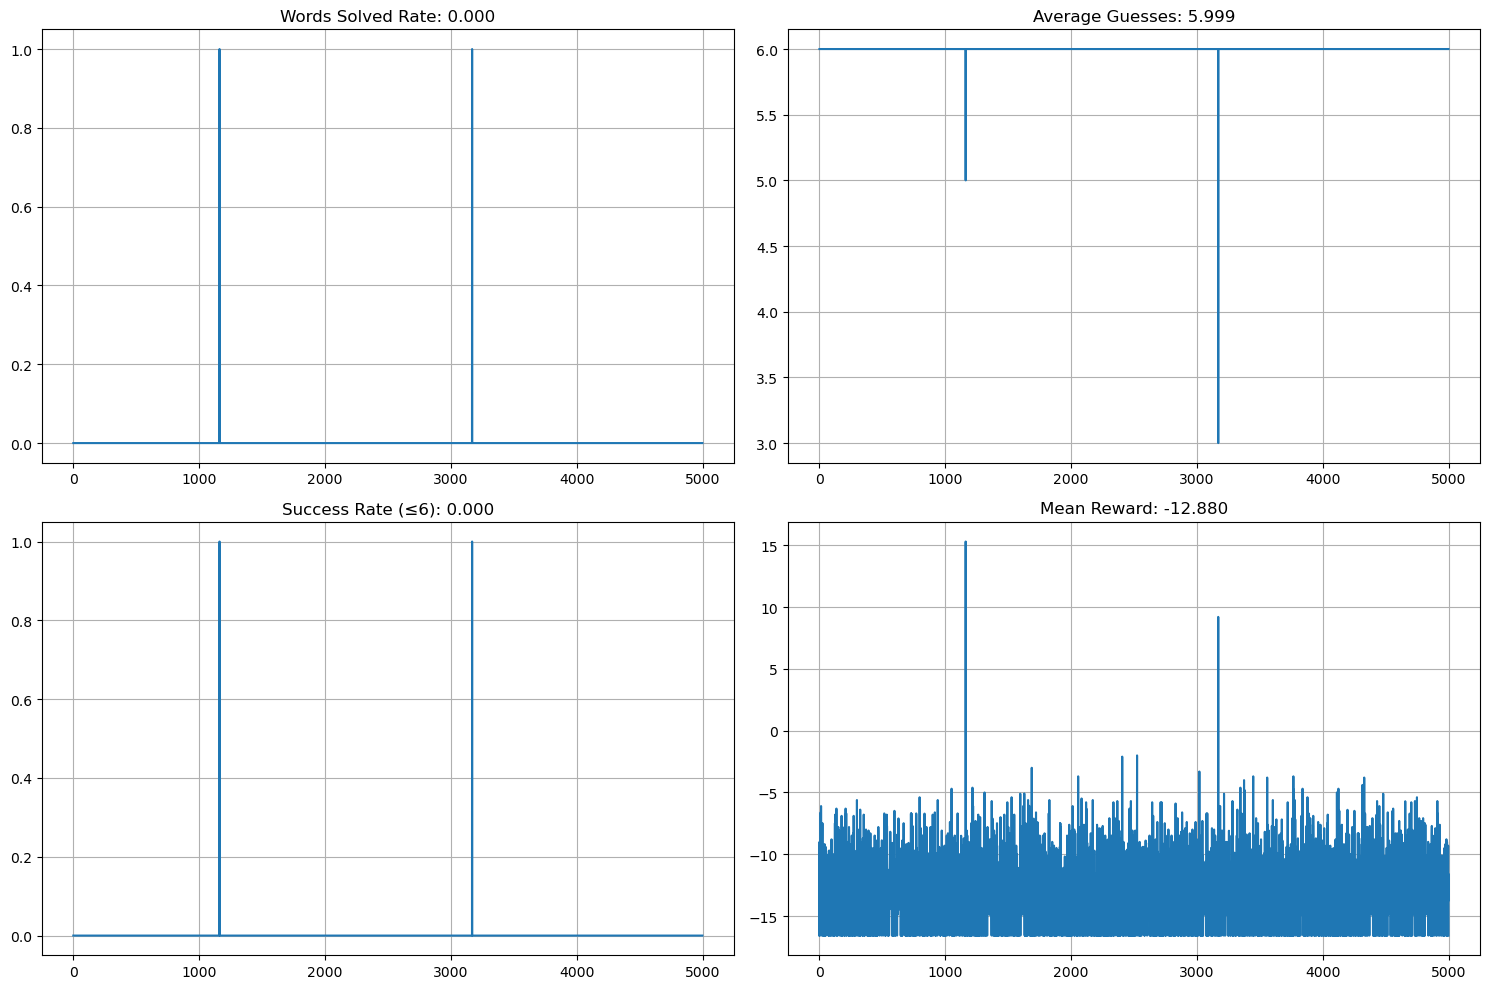

  1%|▏         | 5001/400000 [10:47<45:26:34,  2.41it/s]

  2%|▏         | 9999/400000 [21:32<13:56:35,  7.77it/s]


Progress: 2.5%
Current Epsilon: 1.000
Average Guesses: 6.00
Success Rate (≤6): 0.00
Words Solved: 0.00
Mean Reward: -12.92

Validation Metrics:
Validation Success Rate (≤6): 0.01
Validation Average Guesses: 5.99


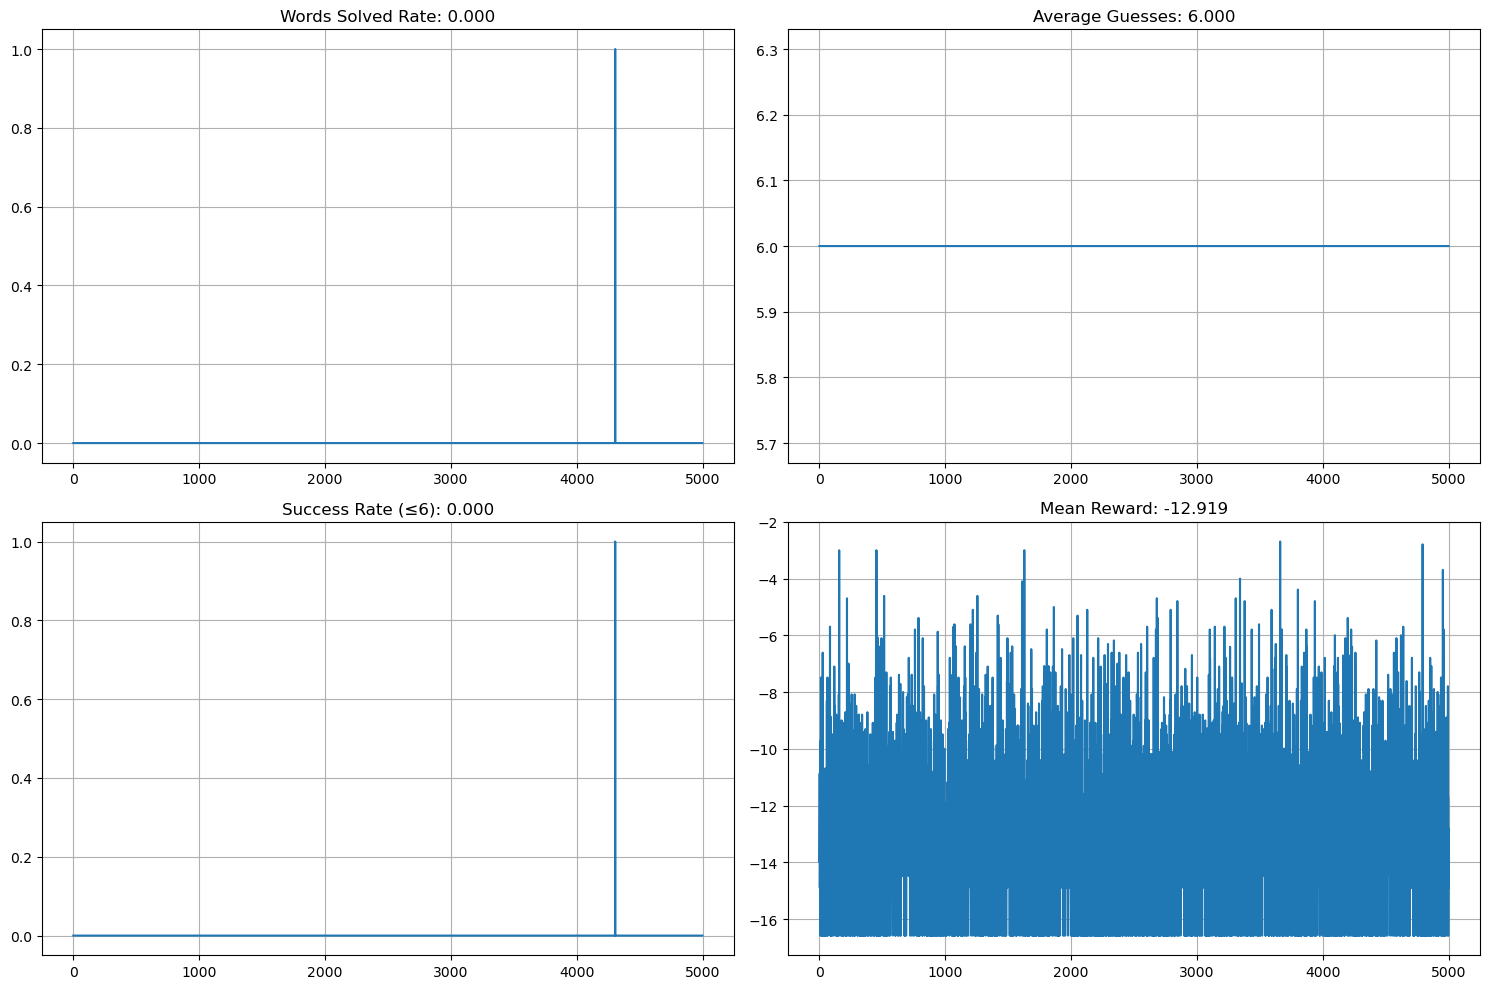

  3%|▎         | 10001/400000 [21:34<46:36:12,  2.32it/s]

  4%|▎         | 14999/400000 [59:18<13:15:39,  8.06it/s]    


Progress: 3.8%
Current Epsilon: 1.000
Average Guesses: 6.00
Success Rate (≤6): 0.00
Words Solved: 0.00
Mean Reward: -12.89

Validation Metrics:
Validation Success Rate (≤6): 0.01
Validation Average Guesses: 5.99


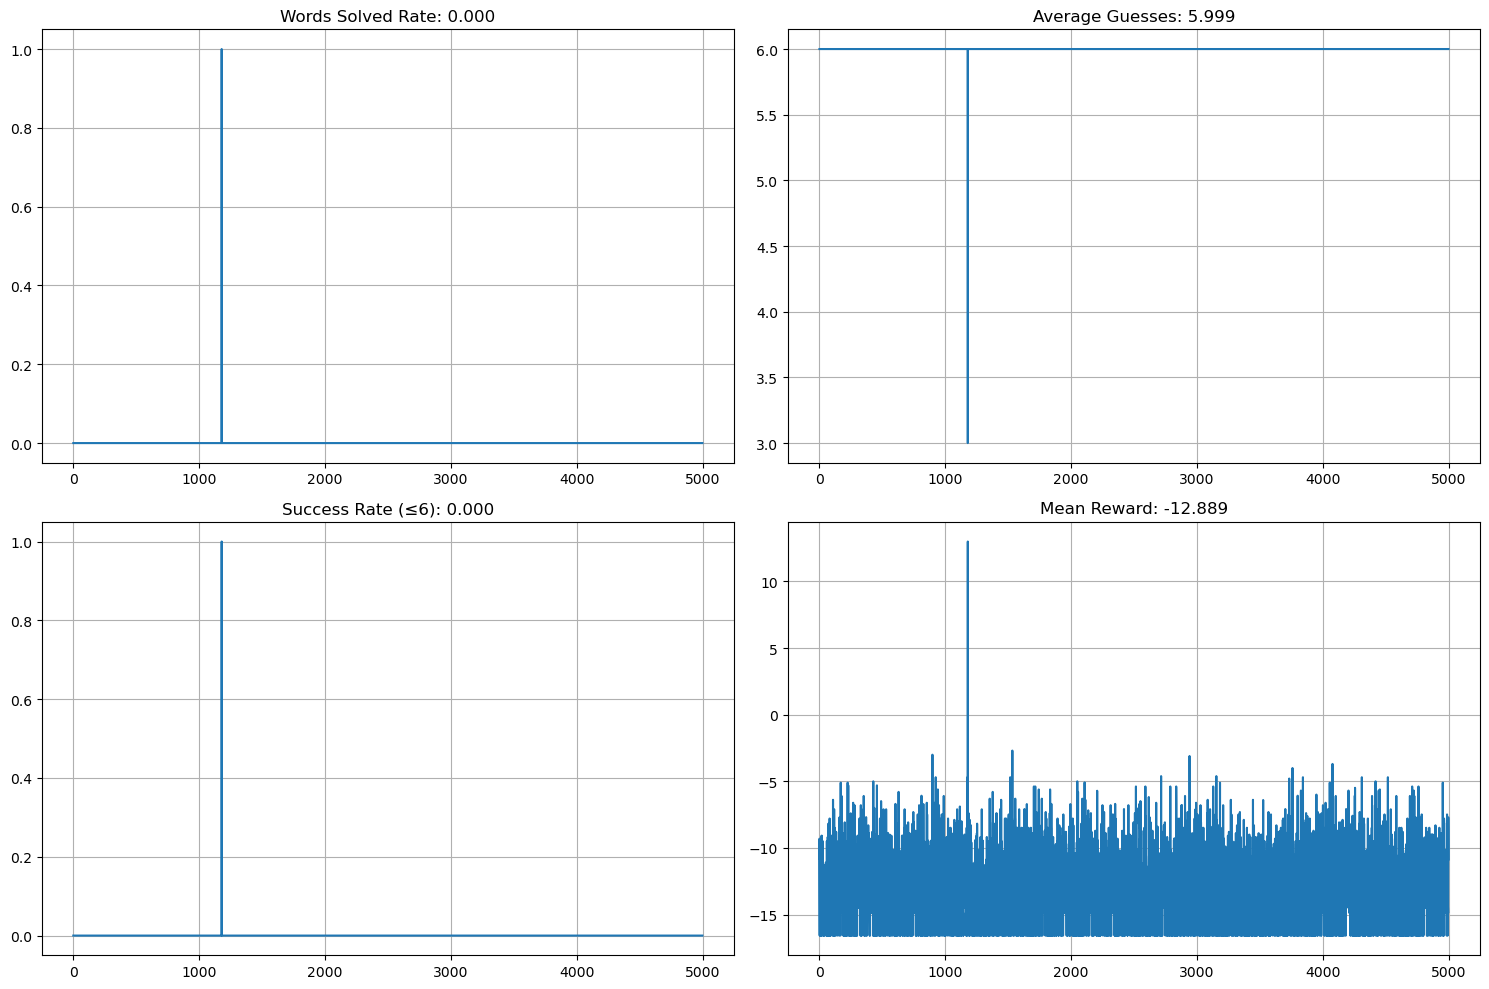

  4%|▍         | 15001/400000 [59:20<43:46:25,  2.44it/s]

  5%|▍         | 19999/400000 [1:10:44<13:09:38,  8.02it/s]


Progress: 5.0%
Current Epsilon: 1.000
Average Guesses: 6.00
Success Rate (≤6): 0.00
Words Solved: 0.00
Mean Reward: -12.87

Validation Metrics:
Validation Success Rate (≤6): 0.01
Validation Average Guesses: 5.99


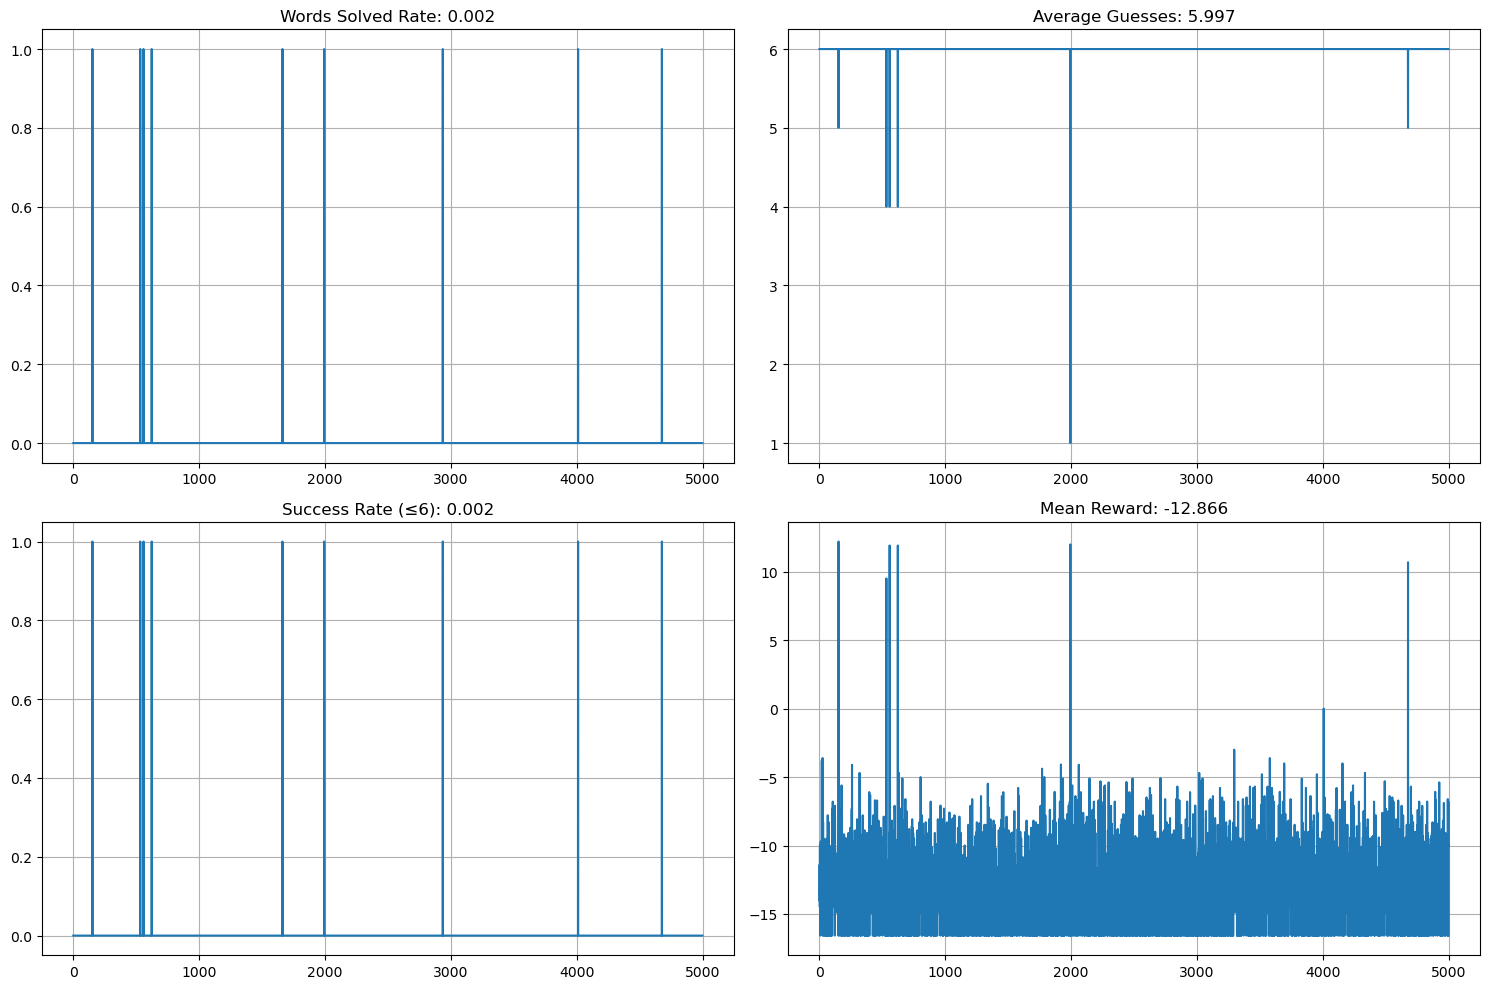

  5%|▌         | 20001/400000 [1:10:45<48:22:38,  2.18it/s]

  5%|▌         | 21750/400000 [1:14:57<21:43:41,  4.84it/s]


KeyboardInterrupt: 

In [39]:
# Train model
model, metrics = train_hangman_agent(train_words, val_words)